# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
import evaluation_vectorization as ev
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 0

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'VertebralColumn_c3'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([310, 6]), torch.Size([310]), 310, 6, 3)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.3557, 0.5198, 0.2292, 0.2509, 0.3075, 0.0252],
        [0.1245, 0.2967, 0.0986, 0.1446, 0.4767, 0.0364],
        [0.4117, 0.5139, 0.3230, 0.3076, 0.3862, 0.0175],
        [0.4162, 0.5573, 0.2713, 0.2894, 0.3419, 0.0518],
        [0.2272, 0.2894, 0.1282, 0.2470, 0.4096, 0.0442],
        [0.1360, 0.3657, 0.0995, 0.1199, 0.6479, 0.0309],
        [0.2631, 0.4003, 0.2074, 0.2239, 0.5430, 0.0397],
        [0.1854, 0.3092, 0.1346, 0.1966, 0.5075, 0.0009],
        [0.1701, 0.3587, 0.2568, 0.1563, 0.5906, 0.0567],
        [0.1017, 0.2065, 0.2501, 0.1694, 0.1523, 0.0273]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
valid_rate = 0.2
test_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_valid = min(2048, int(E*valid_rate))
E_test = min(2048, int(E*test_rate))


random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_valid])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_valid-E_test])

len(train_data), len(valid_data), len(test_data)

(186, 62, 62)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

# Aging Aware PNN

In [11]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

In [12]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, config.M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(config.K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [13]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [14]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.lr)
train_loss_AAPNN, valid_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, valid_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_valid, config.K_valid,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=2000, cache=ds)

  0%|          | 0/2000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.28798 | Loss: 0.948097289 |
| Epoch:   100 | Accuracy: 0.64290 | Loss: 0.587036908 |
| Epoch:   200 | Accuracy: 0.66137 | Loss: 0.550767243 |
| Epoch:   300 | Accuracy: 0.72306 | Loss: 0.475425482 |
| Epoch:   400 | Accuracy: 0.75758 | Loss: 0.445303142 |
| Epoch:   500 | Accuracy: 0.76008 | Loss: 0.423259586 |
| Epoch:   600 | Accuracy: 0.82121 | Loss: 0.321382940 |
| Epoch:   700 | Accuracy: 0.79927 | Loss: 0.351339340 |
| Epoch:   800 | Accuracy: 0.80734 | Loss: 0.346741438 |
| Epoch:   900 | Accuracy: 0.81427 | Loss: 0.334933698 |
| Epoch:  1000 | Accuracy: 0.82508 | Loss: 0.310016274 |
| Epoch:  1100 | Accuracy: 0.81613 | Loss: 0.312299967 |
| Epoch:  1200 | Accuracy: 0.80887 | Loss: 0.335065395 |
| Epoch:  1300 | Accuracy: 0.82589 | Loss: 0.323296636 |
| Epoch:  1400 | Accuracy: 0.80500 | Loss: 0.374256074 |
| Epoch:  1500 | Accuracy: 0.82065 | Loss: 0.322617739 |
| Epoch:  1600 | Accuracy: 0.81540 | Loss: 0.345078886 |
| Epoch:  1700 | Accuracy: 0.82

(1255, 0.29878416657447815)

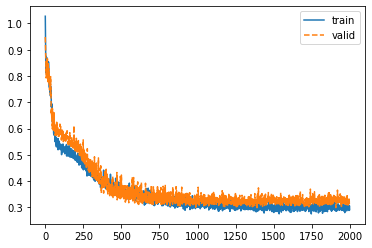

In [15]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(valid_loss_AAPNN, '--', label='valid')
plt.legend()
best = np.argmin(valid_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, valid_loss_AAPNN[best]

## Save Model

In [16]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)